<a href="https://colab.research.google.com/github/carlosbarrone/public_notebooks/blob/main/news_category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Text Classification for Marketing Analytics DTSA-5798: Final Project

## Imports, Project Constants

In [1]:
WORKING_DIR = "/content/drive/MyDrive/ColabNotebooks/msc_ds_boulder/text_mkt_anlysis_specialization/supervised_text_classification"
NEWS_FILE_PATH = f'{WORKING_DIR}/news_category_training_data.json'
RANDOM_SEED = 2023

In [2]:
from google.colab import drive


# Requirements
Install Requirements from requirements.txt file.

In [20]:
drive.mount('/content/drive/')
!cat ./drive/MyDrive/ColabNotebooks/msc_ds_boulder/text_mkt_anlysis_specialization/supervised_text_classification/requirements.txt
!pip install -q -r ./drive/MyDrive/ColabNotebooks/msc_ds_boulder/text_mkt_anlysis_specialization/supervised_text_classification/requirements.txt

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
ktrain
tqdm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [22]:
# IMPORTS
import pandas as pd
import eli5
from ktrain import text, get_learner, get_predictor

## Data Preprocessing

In [5]:
news_df = pd.read_json(NEWS_FILE_PATH)
news_df['full_text'] = news_df.headline + ' ' + news_df.short_description
news_df['is_healthy_living'] = (news_df.category == 'HEALTHY LIVING').astype('int')
print(len(news_df))
news_df.sample(3)

200853


,category,headline,authors,link,short_description,date,full_text,is_healthy_living
12603,POLITICS,Bowe Bergdahl Avoids Jail In Army Desertion Case,Ryan Grenoble,https://www.huffingtonpost.com/entry/bowe-berg...,The soldier pleaded guilty last month.,2017-11-03,Bowe Bergdahl Avoids Jail In Army Desertion Ca...,0
9768,CRIME,Man Arguing With Girlfriend Threw Good Samarit...,David Moye,https://www.huffingtonpost.com/entry/gregory-r...,"The victim, who fell 45 feet into icy waters, ...",2017-12-12,Man Arguing With Girlfriend Threw Good Samarit...,0
197183,PARENTING,Youth Sports: Getting It Right For Kids,"Claire McCarthy, M.D., Contributor\nPediatrici...",https://www.huffingtonpost.com/entry/youth-spo...,Although theoretically we parents are supposed...,2012-03-07,Youth Sports: Getting It Right For Kids Althou...,0


Balancing classes

In [6]:
total_healthy_living_articles = sum(news_df.is_healthy_living)
total_healthy_living_articles

6694

In [7]:
news_df_balanced = pd.concat([
    news_df[news_df.is_healthy_living.astype(bool)],
    news_df[~news_df.is_healthy_living.astype(bool)].sample(total_healthy_living_articles, random_state=RANDOM_SEED)
])
news_df_balanced.describe()

,is_healthy_living
count,13388.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


Pre-Processing

In [8]:
trn, val, preproc = text.texts_from_df(
    news_df_balanced,
    'full_text',
    label_columns=['is_healthy_living'],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.15,
    ngram_range=1,
    preprocess_mode='distilbert',
    verbose=1
)

['not_is_healthy_living', 'is_healthy_living']
        not_is_healthy_living  is_healthy_living
125841                    1.0                0.0
118258                    0.0                1.0
29089                     0.0                1.0
44762                     1.0                0.0
11219                     1.0                0.0
['not_is_healthy_living', 'is_healthy_living']
        not_is_healthy_living  is_healthy_living
112369                    0.0                1.0
54274                     0.0                1.0
113162                    0.0                1.0
13375                     0.0                1.0
67172                     1.0                0.0


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 58
	99percentile : 71


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 28
	95percentile : 59
	99percentile : 69


## Model

In [9]:
model = preproc.get_classifier()
learner = get_learner(model, trn, val, batch_size=18)

### Hyper-Parameter Tunning

In [10]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
632/632 [==============================] - 629s 970ms/step - loss: 0.6612 - accuracy: 0.6131
Epoch 2/6
632/632 [==============================] - 616s 976ms/step - loss: 0.3804 - accuracy: 0.8450
Epoch 3/6
632/632 [==============================] - 615s 973ms/step - loss: 0.4421 - accuracy: 0.7667
Epoch 4/6
632/632 [==============================] - 606s 959ms/step - loss: 0.6972 - accuracy: 0.5019
Epoch 5/6
632/632 [==============================] - 314s 497ms/step - loss: 44.7629 - accuracy: 0.4935


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


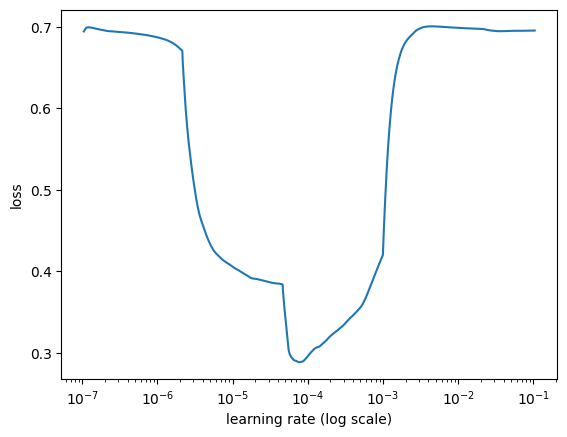

In [11]:
learner.lr_plot()

## Project Model & Training

In [12]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
633/633 [==============================] - 643s 1000ms/step - loss: 0.3922 - accuracy: 0.8353 - val_loss: 0.3169 - val_accuracy: 0.8621
Epoch 2/10
633/633 [==============================] - 628s 992ms/step - loss: 0.2319 - accuracy: 0.9140 - val_loss: 0.3201 - val_accuracy: 0.8671
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [24]:
predictor = get_predictor(learner.model, preproc=preproc)

## Model Validation & Testing

In [25]:
validation = learner.validate(val_data=val, print_report=True)

63/63 [==============================] - 14s 211ms/step
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1004
           1       0.84      0.90      0.87      1005

    accuracy                           0.86      2009
   macro avg       0.86      0.86      0.86      2009
weighted avg       0.86      0.86      0.86      2009



In [26]:
texts = ['Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.']
probabilities = [predictor.predict(text, return_proba=True) for text in texts]

In [27]:
for ((prob_no, prob_yes),text) in zip(probabilities, texts):
  print("---------------------------")
  print(f'The probability this is healthy is {prob_yes}')
  print(text)

---------------------------
The probability this is healthy is 0.9514443278312683
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.9446145296096802
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.7123000621795654
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.9131361246109009
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.011181632056832314
Cuomo Will Not Be Prosecu

In [28]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

/usr/local/lib/python3.10/dist-packages/ktrain/text/predictor.py:139: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)
